# PyTorch MNIST

I wanted to spend some time getting familiar with PyTorch, so I figured what better way than playing with some MNIST data? We'll walk through some simple analysis of our dataset, then try a few neural networks using PyTorch!

Libraries
---------

We'll bring in the regular scientific python stack, plus our group of PyTorch modules.
- torch: For our purposes, this will provide and interface for interacting with Tensors and other library tools.
- torch.nn: Opens up the full neural network capability.
- torch.init: Allows us to deploy custom weight initializations.
- torch.optim: Complete suite of optimization algorithms for weight updates.
- torch.autograd: Provides access to Variables. Powerful extensions of Tensors that allow for optimization.
- torch.nn.functional: Some functional components for activations.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

from torch.autograd import Variable
from torch.nn.functional import relu, softmax, sigmoid

# Use seaborn for cleaner looking plots.
try:
    import seaborn as sns
except ImportError:
    pass

%matplotlib inline

# Constants
SAMPLING = .7
BATCH_SIZE = 64
EPOCHS = 25

# Data Inspection

We can lead off our analysis by checking a sample of our raw data. By heading the input from our pandas dataframe, we can see that the data is provided row-wise. We'll have to reshape in order to apply convolutional methods to our data.

In [2]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Normalization and Scaling

Before we begin any training procedures, we'll normalize and scale our data. In addition to data preprocessing, we're going to limit ourselves to 5000 total samples. This is because I'm running this on a macbook and it takes forever to finish otherwise.

In [3]:
# Reshape for training and testing split.
y_ = train.values[:5000, 0]
x_ = train.values[:5000, 1:]

# Normalize and scale.
x_ = (x_ - x_.mean(axis=0)) / x_.std(axis=0)
x_ = (x_ - x_.min(axis=0)) / (x_.max(axis=0) - x_.min(axis=0))
x_[np.isnan(x_)] = 0
x_ = x_.reshape(len(x_), 1, 28, 28)

# Shuffle data.
np.random.seed(1)
idx = np.random.permutation(len(x_))
y_ = y_[idx]
x_ = x_[idx]

# Split into testing and validation sets.
x_train = x_[int(SAMPLING * len(x_)):].astype(np.float32)
y_train = y_[int(SAMPLING * len(y_)):].astype(np.int64)
x_val = x_[:int(SAMPLING * len(x_))].astype(np.float32)
y_val = y_[:int(SAMPLING * len(y_))].astype(np.int64)

# Convert to PyTorch variables.
x_train = Variable(torch.from_numpy(x_train))
y_train = Variable(torch.from_numpy(y_train))
x_test = Variable(torch.from_numpy(x_val), volatile=True)
y_test = Variable(torch.from_numpy(y_val), volatile=True)

/Users/briantodd/.virtualenvs/whoop-analytics/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


# Data Visualization

MNIST provides a large set of 28x28 grayscale images. Even knowing that in advance, it's helpful to visualize our samples and learn a little bit more about the distribution of these images.

Image Sample
------------

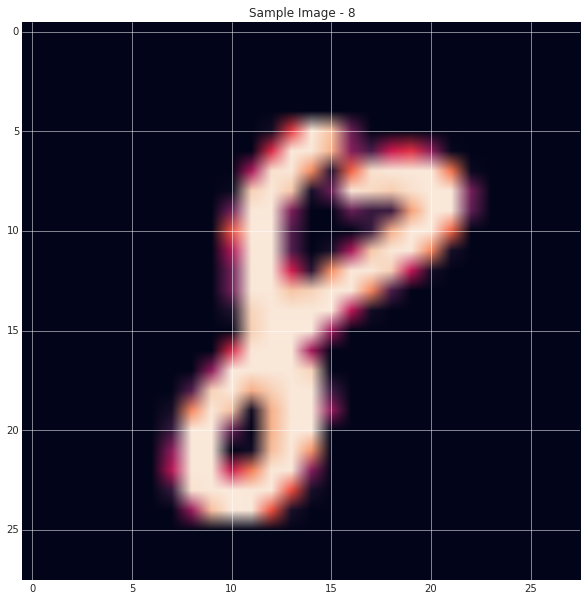

In [12]:
# Sample image.
idx = np.random.randint(len(x_val))
sample_image = x_val[idx].reshape(28, 28)
sample_label = y_val[idx]

# Color map.
sns.set_style('darkgrid')
plt.figure(figsize=(20, 10))
plt.imshow(sample_image)
plt.title('Sample Image - {}'.format(sample_label))
plt.show()

Sample Histogram
----------------

It may be informative to check the histogram of our sample, to see what a typical range of normalized values looks like. In this case, the overwhelming majority of the data is around zero, with a few regions activating. This should be intuitive form the proportion of "drawn space" to empty space in the sample image.

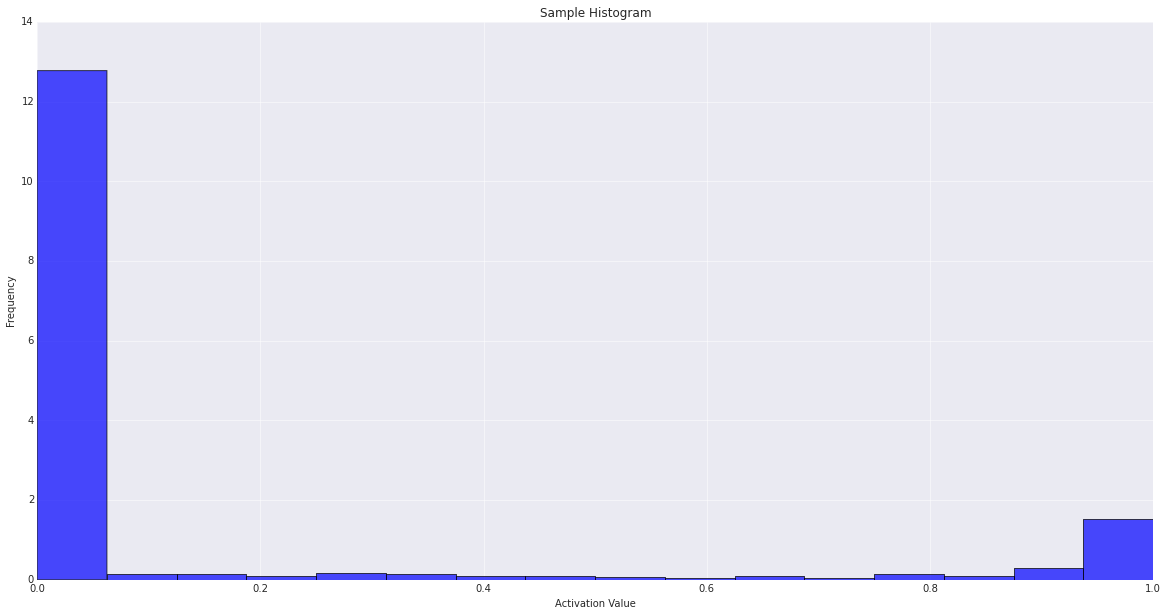

In [13]:
# Histograms of values.
plt.figure(figsize=(20, 10))
plt.hist(sample_image.ravel(), 16, normed=True, alpha=.7)
plt.title('Sample Histogram')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()

Mean Activations
----------------

Another interesting item to note would be the mean activation by tile in our image. This will provide some insight into where the images are active vs. inactive. Our intuition tells us the middle will have higher density than the outer regions. There are a few tails above and below our hyper dense middle, and virtually nothing else is active in the image.

We can perform a similar check for variance in our image activations. In this case, we can see again a high amount of density in the middle of the image; however, there is significant various in a large portion of our average image.

These checks are valuable in that they provide us insight on what we'll expect our convolutions to be doing at each region within the image, why some images would be considered outliers, and what kind of space we would expect an image to be reconstructed in.

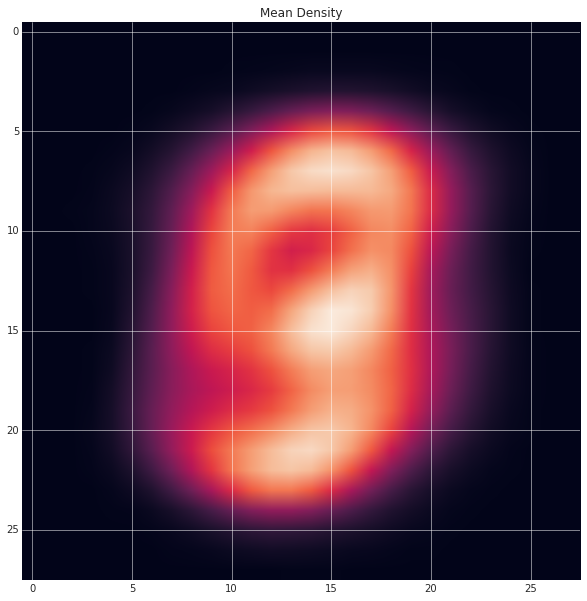

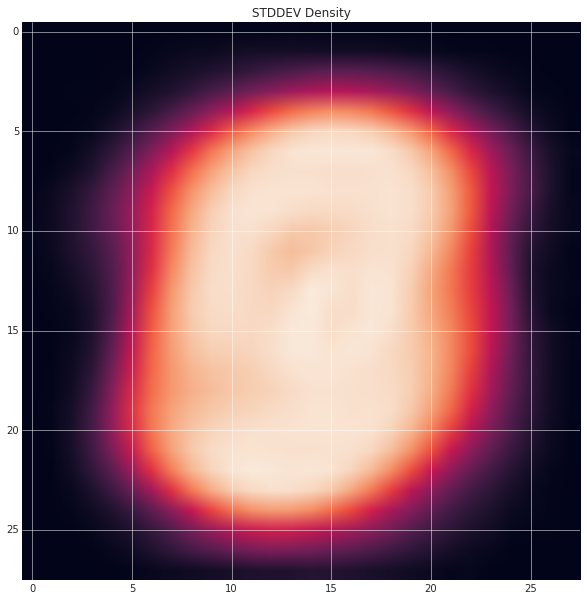

In [14]:
train_mean_vector = train.values[:, 1:].mean(axis=0)
train_std_vector = train.values[:, 1:].std(axis=0)

# Mean density.
plt.figure(figsize=(20, 10))
plt.title('Mean Density')
plt.imshow(train_mean_vector.reshape(28, 28))
plt.show()

# Std density.
plt.figure(figsize=(20, 10))
plt.title('STDDEV Density')
plt.imshow(train_std_vector.reshape(28, 28))
plt.show()

# Convolutional Neural Network - Classification

Now that we're nice and familiar with our data, let's put together a basic ConvNet for image classification! Some notes on our model:

- PyTorch expects our inputs as (batch, channels, height, width).
- We have 10 total classes to predict.
- Cross entropy loss and accuracy will be our main metrics.
- Pooling to save some computational time at the FC stage.
- Initialize weights orthogonally as a first pass. Will help provide stable convergence in some cases.
- We can stick to ReLUs to keep things simple.
- Add small L2 regularization in our optimizer.
- Use ADAM as our optimization algorithm.
- Batch Normalization is applied at almost every layer. This ought to speed up convergence and prevent some level of overfitting.

We'll average the results on our mini-batches by epoch to monitor loss and accuracy. Training and testing metrics will be computed in seperate loops, with training being batched for the purposes of memory management.

In [7]:
# Implement basic convolutional neural network for classification.
class ConvNet(nn.Module):
    '''
    Testbed for pytorch networks.
    '''

    def __init__(self):
        super(ConvNet, self).__init__()

        self.nodes = 784

        # Network topology.
        # Feature extraction layers.
        self.pool   = nn.AvgPool2d(2)
        self.conv1  = nn.Conv2d(1, 128, 4, stride=1, padding=0)
        self.conv2  = nn.Conv2d(128, 64, 2, stride=1, padding=1)
        self.conv3  = nn.Conv2d(64, 16, 2, stride=1, padding=1)

        # Fully connected classification layers.
        self.fc1    = nn.Linear(self.nodes, 64)
        self.fc2    = nn.Linear(64, 32)
        self.fc3    = nn.Linear(32, 10)
        
        # Batch normalization layer, to prevent overfitting.
        # 2D BatchNorm for convolutional layers.
        self.conv_bn1    = nn.BatchNorm2d(128)
        self.conv_bn2    = nn.BatchNorm2d(64)
        self.conv_bn3    = nn.BatchNorm2d(16)
        
        # 1D BatchNorm for fully connected layers.
        self.fc_bn1      = nn.BatchNorm1d(64)
        self.fc_bn2      = nn.BatchNorm1d(32)

        # Custom weight initializations.
        init.orthogonal(self.conv1.weight, 1.)
        init.orthogonal(self.conv2.weight, 1.)
        init.orthogonal(self.conv3.weight, 1.)
        init.orthogonal(self.fc1.weight, 1.)
        init.orthogonal(self.fc2.weight, 1.)
        init.orthogonal(self.fc3.weight, 1.)


    def forward(self, x): 
        '''
        Forward pass across test topology.
        '''

        x = self.conv_bn1(relu(self.conv1(x)))
        x = self.pool(x)
        x = self.conv_bn2(relu(self.conv2(x)))
        x = self.pool(x)
        x = self.conv_bn3(relu(self.conv3(x)))
        x = x.view(-1, self.nodes)
        x = self.fc_bn1(relu(self.fc1(x)))
        x = self.fc_bn2(relu(self.fc2(x)))
        x = softmax(self.fc3(x))

        return x

Training Routine
---

This portion ended up being much more verbose than necessary, only because we wanted to track and report so many metrics. In general, the plan is to run batches of our data through the network as a forward, and optimized via backpropagation in the backward pass. While doing this, it is incredibly important to switch track metrics for both training and testing, so that we can verify we haven't overfit.

As a final note, we'll collect our metrics on each epoch and each mini-batch to thoroughly summarize how our results change with optimization.

In [8]:
# Run training routine.
net = ConvNet()
print(net)

# Zero gradient set loss function.
optimizer = optim.Adam(net.parameters(), weight_decay=0.015)
loss_function = nn.CrossEntropyLoss()

# Prep lists for storing loss and accuracy metrics.
loss_epoch_test, accuracy_epoch_test = [], []
loss_epoch_train, accuracy_epoch_train = [], []

loss_mbat_test, accuracy_mbat_test = [], []
loss_mbat_train, accuracy_mbat_train = [], []

# Run training routine.
for epoch in range(EPOCHS):
    
    # Main training loop.
    running_loss_train = 0.
    running_acc_train = 0.
    net.train()
    for idx in range(len(x_train) // BATCH_SIZE):

        # Sample minibatch from training set.
        input_sample = x_train[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        target_sample = y_train[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]        

        # Zero gradient.
        optimizer.zero_grad()   

        # Compute outputs from network.
        outs = net(input_sample)
        loss = loss_function(outs, target_sample)

        # Update parameters.
        loss.backward()
        optimizer.step()

        # Running loss and accuracy per training epoch.
        running_loss_train += loss.data[0]
        preds = torch.max(outs.data, dim=1)[-1]
        acc = (preds == target_sample.data).sum() / len(target_sample)
        running_acc_train += acc
        
        # Loss and accuracy per training mini batch.
        loss_mbat_test.append(loss.data[0])
        accuracy_mbat_test.append(acc)

    # Testing loop for validation metrics.
    # We want our testing run to be after each epoch on the training data.
    # This testing loop is batched to avoid memory issues.
    running_loss_test = 0.
    running_acc_test = 0.
    net.eval()
    for idx_test in range(len(x_test) // BATCH_SIZE):
        
        # Sample minibatch from testing set.
        input_sample = x_test[idx_test * BATCH_SIZE:(idx_test + 1) * BATCH_SIZE]
        target_sample = y_test[idx_test * BATCH_SIZE:(idx_test + 1) * BATCH_SIZE]
        
        # Compute outputs from network with testing data.
        outs = net(input_sample)
        loss = loss_function(outs, target_sample)
        
        # Running loss and accuracy for testing data.
        running_loss_test += loss.data[0]
        preds = torch.max(outs.data, dim=1)[-1]
        acc = (preds == target_sample.data).sum() / len(target_sample)
        running_acc_test += acc
        
        # Loss and accuracy per testing mini batch.
        loss_mbat_train.append(loss.data[0])
        accuracy_mbat_train.append(acc)

    # Append loss and accuracy metrics.
    loss_epoch_train.append(running_loss_train / (idx + 1))
    loss_epoch_test.append(running_loss_test / (idx_test + 1))
    
    accuracy_epoch_train.append(running_acc_train / (idx + 1))
    accuracy_epoch_test.append(running_acc_test / (idx_test + 1))

    print('Epoch: {}'.format(epoch + 1))
    print('\tLoss (Test: {0}, Train: {1})'.format(loss_epoch_test[-1], loss_epoch_train[-1]))
    print('\tAccuracy (Test: {0}, Train: {1})\n'.format(accuracy_epoch_test[-1], accuracy_epoch_train[-1]))

ConvNet (
  (pool): AvgPool2d (
  )
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear (784 -> 64)
  (fc2): Linear (64 -> 32)
  (fc3): Linear (32 -> 10)
  (conv_bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv_bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (fc_bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
  (fc_bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
)
Epoch: 1
	Loss (Test: 2.288574629359775, Train: 2.1671424844990606)
	Accuracy (Test: 0.2271412037037037, Train: 0.5577445652173914)

Epoch: 2
	Loss (Test: 2.1477638571350663, Train: 2.000335314999456)
	Accuracy (Test: 0.8177083333333334, Train: 0.8559782608695652)

Epoch: 3
	Loss (Test: 1.956866964145943, Train: 1.87127015383

Results
---

Even with our simple network and training scheme, we can train our network to have ~97% testing accuracy. While that is generally considered a poor score for MNIST data, we'll at least temporarily consider it a success in demonstrate basically ConvNet functionality. We can explore how our metrics change with each epoch below, as we initially make large strides in accuracy before experiencing diminishing returns.

There are many, many changes that could be made to improve this model, but this sits well as a first pass.

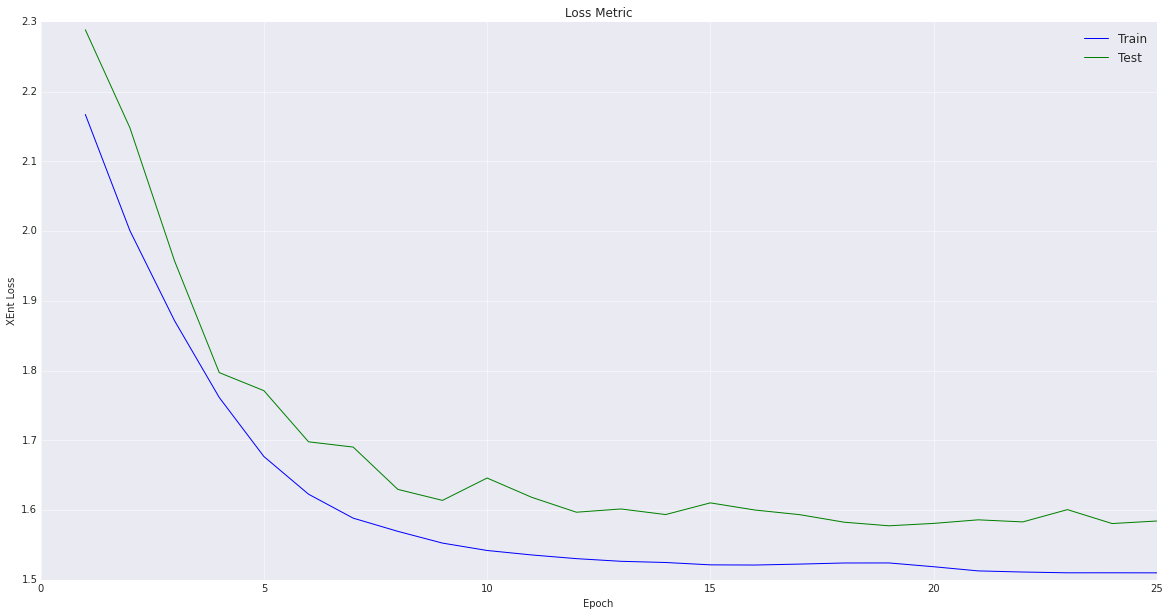

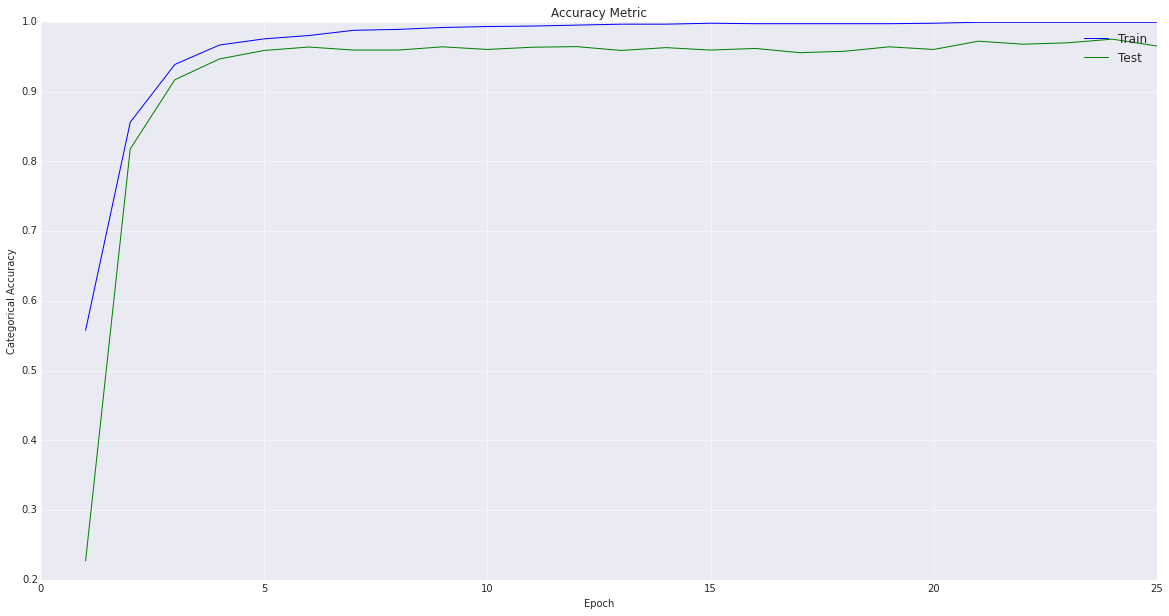

In [15]:
# Plot out the testing and training accuracy and loss charts.
# First procede with XEnt loss.
plt.figure(figsize=(20, 10))
plt.title('Loss Metric')
plt.plot((np.arange(len(loss_epoch_train)) + 1), loss_epoch_train, color='Blue', label='Train')
plt.plot((np.arange(len(loss_epoch_test)) + 1), loss_epoch_test, color='Green', label='Test')
plt.xlabel('Epoch')
plt.ylabel('XEnt Loss')
plt.legend()
plt.show()

# Plot categorical accuracy.
plt.figure(figsize=(20, 10))
plt.title('Accuracy Metric')
plt.plot((np.arange(len(accuracy_epoch_train)) + 1), accuracy_epoch_train, color='Blue', label='Train')
plt.plot((np.arange(len(accuracy_epoch_test)) + 1), accuracy_epoch_test, color='Green', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()